# Traffic Sign Recognition
----

Progetto del corso di Machine Learning AA 2017/2018

Corso di Laurea Magistrale in Informatica, Università di Bologna

- Ceccolini Enrico (matricola )
- Valguarnera Enrico (800115)


Il progetto consiste nell'analisi ed implementazione di alcune delle soluzioni presentate nel paper *Traffic Sign Recognition with Multi-Scale Convolutional Networks* redatto da Pierre Sermanet e Yann LeCun. Tale studio racchiude le tecniche principali avanzate da diversi team di ricercatori (tra cui il loro) durante le competizioni IJCNN, sfide che avevano come obiettivo la realizzazione del miglior classificatore di segnali stradali (single-image, multi-class classification problem) partendo dal dataset GTSRB, dataset che impareremo a conoscere.

E' possibile reperire il paper [qui]('http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf').

In particolare si cercherà di aderire alle tecniche proposte di: aumento del dataset, normalizzazione del dataset e di definizione delle reti neurali, proponendo alcune modifiche o integrazioni per il miglioramento dei modelli risultanti. 

# 1) Il Dataset GTSRB
---

Per uniformità al paper è stato scelto di utilizzare la versione del dataset indicata per l'*online competition stage*, non l'ultima presentata dall'istituto che si occupa delle competizioni. 

E' possibile ottenere il dataset [qui]('http://benchmark.ini.rub.de/index.php?section=gtsrb&subsection=dataset#Downloads').

Questa contiene 39209 immagini in totale, divise tra tra training-set (26,640 immagini) e test-set (12,569 immagini). Ogni immagine contiene un singolo segnale stradale appartenente ad una delle 43 classi presenti. Le dimensioni delle immagini variano da un minimo di 15x15 ad un massimo di 250x250 pixel.

Le immagini contenute nel dataset presentano molteplici difficoltà, per rispecchiare al meglio i problemi che si presentano nel mondo reale: diverse inquadrazioni del segnale stradale, condizioni di luce (irradiazione, saturazione e basso contrasto), sfocature dovute al movimento del veicolo, danni fisici, graffiti, adesivi e bassa risoluzione.

#### Lista delle classi di segnali stradali:

In [1]:
import my_mod_load as load
print(load.get_classes())

['0: Speed limit (20km/h)', '1: Speed limit (30km/h)', '2: Speed limit (50km/h)', '3: Speed limit (60km/h)', '4: Speed limit (70km/h)', '5: Speed limit (80km/h)', '6: End of speed limit (80km/h)', '7: Speed limit (100km/h)', '8: Speed limit (120km/h)', '9: No passing', '10: No passing for vehicles over 3.5 metric tons', '11: Right-of-way at the next intersection', '12: Priority road', '13: Yield', '14: Stop', '15: No vehicles', '16: Vehicles over 3.5 metric tons prohibited', '17: No entry', '18: General caution', '19: Dangerous curve to the left', '20: Dangerous curve to the right', '21: Double curve', '22: Bumpy road', '23: Slippery road', '24: Road narrows on the right', '25: Road work', '26: Traffic signals', '27: Pedestrians', '28: Children crossing', '29: Bicycles crossing', '30: Beware of ice/snow', '31: Wild animals crossing', '32: End of all speed and passing limits', '33: Turn right ahead', '34: Turn left ahead', '35: Ahead only', '36: Go straight or right', '37: Go straight o

#### Load del dataset

In [2]:
train, valid, test = load.load_train_valid_test()

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

#### Visualizzazione di alcuni campioni estratti casualmente

Di seguito il plot di 43 immagini (una per classe) raffiguranti segnali stradali. La sequenza segue quella della stampa delle classi presente sopra.

In [3]:
load.display_sample_images(X_train, y_train)

#### Istogramma rappresentante la distribuzione di campioni per classe

Come è ben vidibile dal grafico, la quantità di campioni per classe è molto sbilanciata. Il paper non interviene su questa situazione con tecniche di bilanciamento tramite la creazione di nuovi campioni ottenendo comunque un' ottima accuratezza sul test-set.

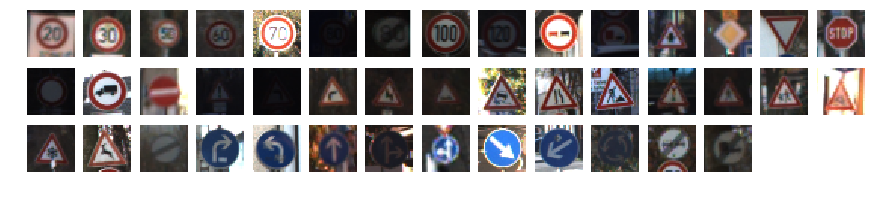

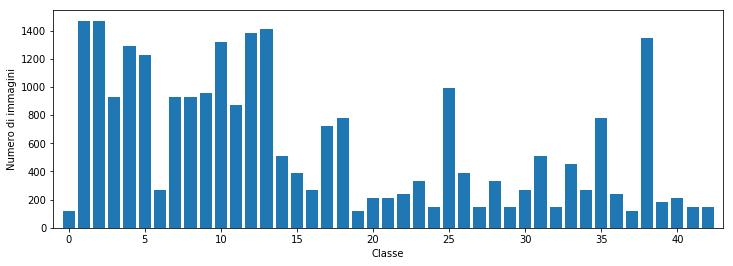

In [4]:
load.display_class_distribution(y_train)

# 2) Data Preparation
---
## 2.1) Valid-set

Come evdenzia il paper, la selezione delle immagini che popoleranno il validation dataset è cruciale in GTSRB. Mischiare le immagini e selezionare un sottoinsieme porterebbe ad avere un validation dataset troppo simile al training dataset e all'impossibilità di ottenere valori di performance del modello accurati.

Il motivo è da trovare nella tecnica utilizzata per ottenere le immagini del dataset. Le immagini sono state estratte da tracce video. Per ogni traccia il segnale stradale presente è stato catturato circa 30 volte con aumento progressivo della risoluzione a mano a mano che la videocamera si avvicinava al segnale.

Per la definizione del validation set si è estratta in maniera casuale una traccia per ognuna delle 43 classi, in modo da non avere immagini dello stesso identico segnale stradale nei diversi insiemi.

In [5]:
print("Dimensione del training-set: {}".format(len(X_train)))
print("Dimensione del valid-set: {}".format(len(X_valid)))

Dimensione del training-set: 25350
Dimensione del valid-set: 1290


## 2.2) Pre-processing
---
Per la fase di pre-processing è stata definita una collezione di funzioni, presente nel file my_mod_manipulate_image.py, utile per la normalizzazione e l'aumento dei dati.

### 2.2.1) Normalization
---
Per ottenere un modello con performance elevate Pierre Sermanet e Yann LeCun consigliano di:
- ridimensionare le immagini alla dimensione 32x32
- convertire lo spazio di colori da RGB a YUV
- applicare una normalizzazione globale sul canale Y
- apllicare una normalizzazione locale sul canale Y
- lasciare inalterati i canali U e V

Al termine del paper si legge che usare i canali colore non aumenta in modo considerevole l'accuratezza del modello generato, per questo motivo consideremo fin da subito la conversione in grayscale considerando solo il canale di luminanza con il vantaggio di poter realizzare reti più piccole e veloci.

Di seguito la funzione da noi utilizzata per la manipolazione di una singola immagine (le immagini sono state ridimensionate durante il caricamento del dataset).

``` Python
def normalize_img(img):
    # converte l'immagine in YUV mantenedo esclusivamente il canale Y (luminanza)
    img_y = cv2.cvtColor(img, (cv2.COLOR_BGR2YUV))[:,:,0]
    
    # Normalizzazione globale
    # distribuisce la luminosità nell'istogramma incrementando il contrasto globale
    img_y = cv2.equalizeHist(img_y) 
    
    # rappresenta i valori in un range da 0 a 1
    img_y = (img_y / 255.).astype(np.float32) 
    
    # Equalizzazione locale
    # esegue la Contrast Limited Adaptive Histogram Equalization
    # l'obbiettivo è quello di enfatizzare gli angoli dei segnali stradali
    img_y = (exposure.equalize_adapthist(img_y) - 0.5) 
    
    img_y = img_y.reshape(img_y.shape + (1,))

    return img_y
```

#### Visualizzazione di un'immagine originale a confronto con una normalizzata


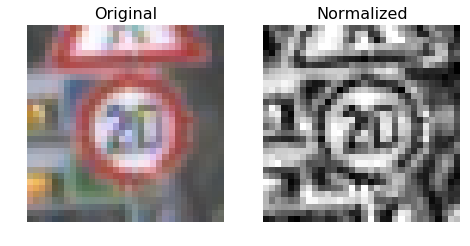

In [6]:
import plot_functions as pltfun
pltfun.original_vs_normalized(X_train[1])

### 2.2.2) Jittering
---
Per ottenere un modello con performance elevate Pierre Sermanet e Yann LeCun consigliano di aumentare i campioni del training-set andando a generare immagini da quelle già presenti.
Le trasformazioni da applicare devono generare segnali stradali plausibili, cioè che differiscano dagli originali per inquadratura della camera posta sull'eventuale veicolo.

Il paper consiglia di perturbare le immagini originali in modo casuale sulle seguenti proprietà con i relativi range:
- posizione ([-2, 2] pixels)
- scala ([.9, 1.1] ratio)
- rotazione ([-15, 15] gradi)

Per l'aumento dei dati è stata utilizzata la libreria Keras. In particolare tramite il modulo ImageDataGeneration. Nel ciclo for sottostante è riportata la generazione di un nuovo insieme di immagini delle stesse dimensioni del training set originario.


```Python
datagen = ImageDataGenerator(
        # perturbed in position ([-2, 2] pixels)
        width_shift_range=0.07, # for images 32x32
        height_shift_range=0.07,
    
        # perturbed in scale ([.9, 1.1] ratio)
        # si è deciso di applicare uno zoom al suo posto
        zoom_range=0.15,

        # perturbed in rotation ([-15, 15] degrees)
        rotation_range=15,
        fill_mode='nearest')

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=len(X_train)):
    X_train_aug = X_batch.astype('uint8')
    y_train_aug = y_batch
    break

```

TODO: Visualizzazione di alcune immagini

### 2.2.3 Blurring
---
Si è deciso di aumentare i campioni del training-set aggiungendo un insieme di immagini corrispondente all'insieme originale al quale è stato applicato un Gaussian blur.

#### kernel  utilizzato = 
\begin{bmatrix}
 0 & 0 & 0 & 0 \\
 1/4 & 1/4 & 1/4 & 1/4 \\
 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0
\end{bmatrix}

 

```Python
def motion_blur(img):
    size = 4
    # generating the kernel
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size
    img_bl = cv2.filter2D(img, -1, kernel_motion_blur)

    return img_bl
```

#### Visualizzazione di un'immagine originale a confronto con una sfocata e successivamente normalizzata.

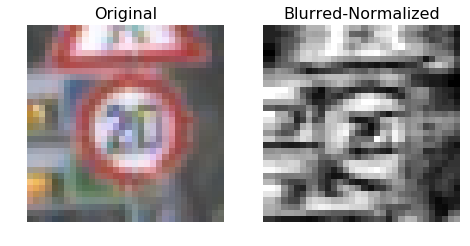

In [7]:
pltfun.orginal_vs_blurred(X_train[1])

#### Load del dataset manipolato

E' stato applicato il jittering cinque volte e il blurring una volta, ottenendo un fattore moltiplicativo x6.

Dimensione del training-set: 152100


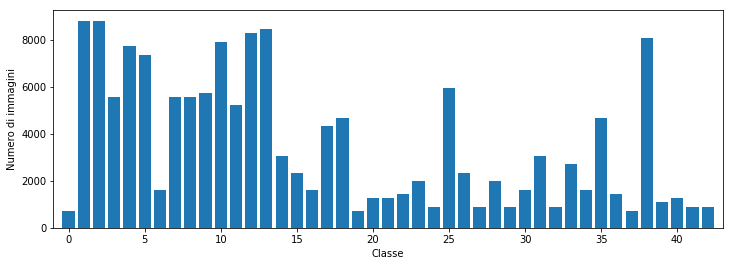

In [8]:
dirname = '2018-02-06_1645_online_augm_blur'

X_train, y_train = load.load_manipulated_train(dirname)
X_valid, y_valid = load.load_normalized_valid(dirname)
X_test, y_test = load.load_normalized_test(dirname)
print("Dimensione del training-set: {}".format(len(X_train)))

load.display_class_distribution(y_train)

## 3) Architecture
---

## 4) Experiments
---

## 5) Test sulle nuove immagini
---

In [3]:
import my_mod_test_new as test_new
l , n_examples, list_fname = test_new.my_test('./final_models/keras/model_108-108_ep20', learning_rate=0.01, batch_size=128)

#print("True Label: {}".format(l[3][1]))
#print("Top3 label: {}".format(l[3][2]))
#print("Top3 prob: {}".format(l[3][3]))
#print(n_examples)

Loaded model from disk

Testing: 
well-aimed: 24/31
well-aimed: 0.7742


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import my_mod_load as mml
import matplotlib.image as mpimg
#images, labels= mml.load_original_image()
print(labels)
plt.figure()
#plt.imshow(images[1][:,:,0])
plt.show()

fig, ax = plt.subplots(n_examples, 2,figsize=(12,60))


for i in range(n_examples):
    labels = l[i][1]
    img = mpimg.imread(list_fname[i])
    names = mml.get_name_from_label(l[i][2])
    bar_locations = np.arange(3)[::-1]
    ax[i,0].imshow(img)
    ax[i,0].axis('off')
    ax[i,1].barh(bar_locations, l[i][3])
    ax[i,1].set_yticks(0.5+bar_locations)
    ax[i,1].set_yticklabels(names)
    ax[i,1].yaxis.tick_right()
    ax[i,1].set_xlim([0,1])
ax[0,1].set_title('Model Prediction')
plt.tight_layout()
plt.show()


NameError: name 'labels' is not defined

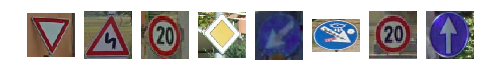

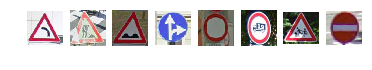

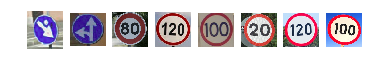

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import transform
from skimage.filters import gaussian
import glob

plt.figure(figsize=(8,8))
set_img = glob.glob('./Sign_image_resized/*.png') + glob.glob('./Sign_image_resized/*.jpg')
#print(set_img)
i = 0
row = 1
col = 8
for item in set_img:
    i += 1
    #if row < 3:
    img = mpimg.imread(item)
    plt.subplot(row, col, i)
    plt.imshow(img)
    plt.axis('off')
    if i == col:
        i = 0
        row += 1
        plt.show()

Altro modo per stampare le immagini. Utilizzando il modulo *os* piuttosto che *glob* .

Ciò risolve la situazione? Vedremo ..

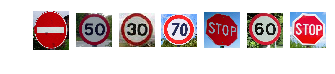

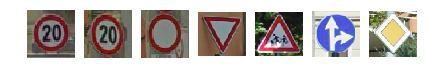

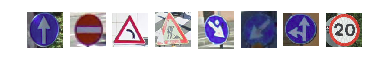

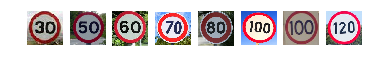

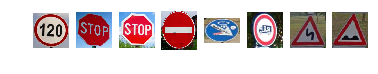

['./Sign_image_resized/data.txt', './Sign_image_resized/img02.png', './Sign_image_resized/img04.png', './Sign_image_resized/img05.png', './Sign_image_resized/img06.png', './Sign_image_resized/img07.png', './Sign_image_resized/img09.png', './Sign_image_resized/img10.png', './Sign_image_resized/img11.png', './Sign_image_resized/img12.png', './Sign_image_resized/img14.png', './Sign_image_resized/img16.png', './Sign_image_resized/img17.png', './Sign_image_resized/img18.png', './Sign_image_resized/img19.jpg', './Sign_image_resized/img20.jpg', './Sign_image_resized/img21.jpg', './Sign_image_resized/img23.jpg', './Sign_image_resized/img24.jpg', './Sign_image_resized/img26.jpg', './Sign_image_resized/img27.jpg', './Sign_image_resized/img28.jpg', './Sign_image_resized/img29.jpg', './Sign_image_resized/img30.jpg', './Sign_image_resized/img31.jpg', './Sign_image_resized/img32.jpg', './Sign_image_resized/img33.jpg', './Sign_image_resized/img34.jpg', './Sign_image_resized/img40.png', './Sign_image_

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import transform
from skimage.filters import gaussian
import glob
import os

plt.figure(figsize=(8,8))
#set_img =glob.glob('./Sign_image_resized/*.(jpg|png)')# +  glob.glob('./Sign_image_resized/*.png')

i = 0
row = 1
col = 8
base_path = './Sign_image_resized/'
#for item in set_img:
list_file = []
for file in sorted(os.listdir('./Sign_image_resized/')):
    file = base_path + file
    list_file.append(file)
    
    i += 1
    #if row < 3:
    if file != './Sign_image_resized/data.txt':   
        img = mpimg.imread(file)
        plt.subplot(row, col, i)
        plt.imshow(img)
        plt.axis('off')
        if i == col:
            i = 0
            row += 1
            plt.show()
print(list_file)

In [11]:
import my_mod_test as test_new
test_new.my_test()

INFO:tensorflow:Restoring parameters from /notebooks/final_models/VGGnet/2018-02-14_0750/lenet
Accuracy Model On Internet Images: 0.8387096524238586
Top 3 Labels for image 'Speed limit (20km/h)':
 - 'Speed limit (20km/h)' with prob = 1.0000 
 - 'Speed limit (70km/h)' with prob = 0.0000 
 - 'Speed limit (30km/h)' with prob = 0.0000 

Top 3 Labels for image 'Speed limit (20km/h)':
 - 'Speed limit (20km/h)' with prob = 0.9999 
 - 'Speed limit (70km/h)' with prob = 0.0000 
 - 'Speed limit (30km/h)' with prob = 0.0000 

Top 3 Labels for image 'No vehicles':
 - 'No vehicles' with prob = 1.0000 
 - 'Speed limit (50km/h)' with prob = 0.0000 
 - 'No passing' with prob = 0.0000 

Top 3 Labels for image 'Yield':
 - 'Yield' with prob = 1.0000 
 - 'End of no passing by vehicles over 3.5 metric tons' with prob = 0.0000 
 - 'No passing for vehicles over 3.5 metric tons' with prob = 0.0000 

Top 3 Labels for image 'Children crossing':
 - 'Beware of ice/snow' with prob = 0.9861 
 - 'Children crossing' 

## Bibliografia

[\[1\] GTSRB - Man vs. computer: Benchmarking machine learning algorithms for traffic sign recognition]('http://dx.doi.org/10.1016/j.neunet.2012.02.016')

[\[2\] OpenCV, EqualizeHist](https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html?highlight=equalizehist)

[\[3\] scikit-image, exposure.equalize_adapthist](http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_adapthist)

https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html